In [18]:
# Про данные:
# Ссылка на источник: https://www.kaggle.com/datasets/pratyushpuri/drug-labels-and-side-effects-dataset-1400-records
# Датасет содержит информацию о лекарственных препаратах, их классах, одобрении FDA и побочных эффектах.

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast  # для безопасного преобразования строки в список
from scipy import stats  # Правильный импорт
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
import re
# Настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

In [15]:
# Загрузка данных
df = pd.read_csv(r'C:\Users\Eduard\Downloads\realistic_drug_labels_side_effects.csv')

In [20]:
#price_usd (таргет) - цена препарата в USD

#dosage_mg - дозировка в мг

#side_effects_count - количество побочных эффектов

#approval_year - год одобрения

#drug_class - терапевтический класс (категориальная)

#Исследовательский вопрос: "Какие факторы влияют на цену лекарственных препаратов и как именно?"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# Проверка данных
print("Размерность данных:", df.shape)
print("\nПропуски:", df.isnull().sum().sum())
print("Дубликаты:", df.duplicated().sum())

# Создаем дополнительные переменные
df['side_effects_list'] = df['side_effects'].apply(lambda x: x.split(', '))
df['side_effects_count'] = df['side_effects_list'].apply(len)


Размерность данных: (1436, 15)

Пропуски: 0
Дубликаты: 0


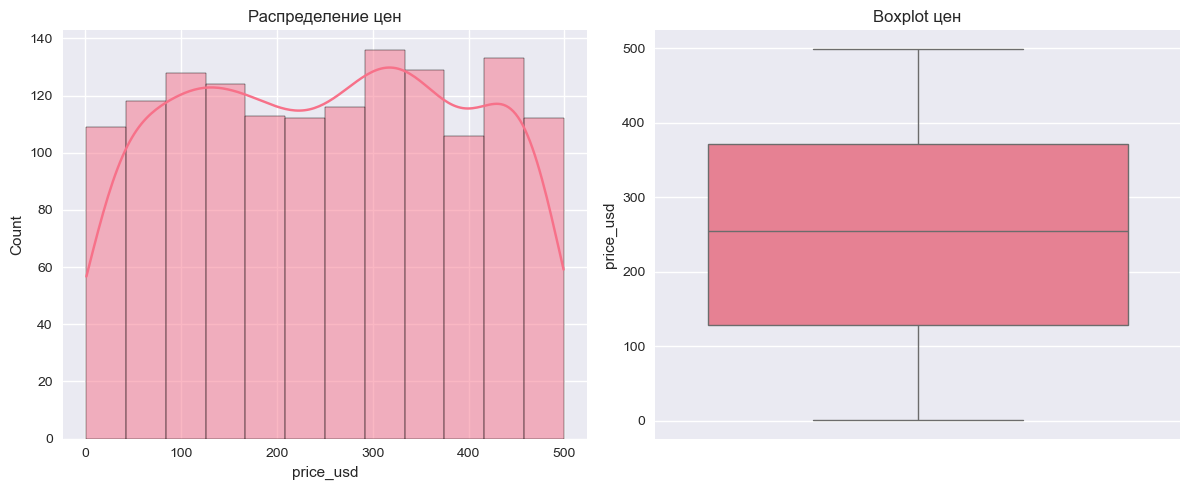

Описательная статистика цены:
count    1436.000000
mean      251.844854
std       142.640781
min         1.210000
25%       128.830000
50%       255.130000
75%       372.207500
max       499.060000
Name: price_usd, dtype: float64


In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['price_usd'], kde=True)
plt.title('Распределение цен')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['price_usd'])
plt.title('Boxplot цен')
plt.tight_layout()
plt.show()

print("Описательная статистика цены:")
print(df['price_usd'].describe())

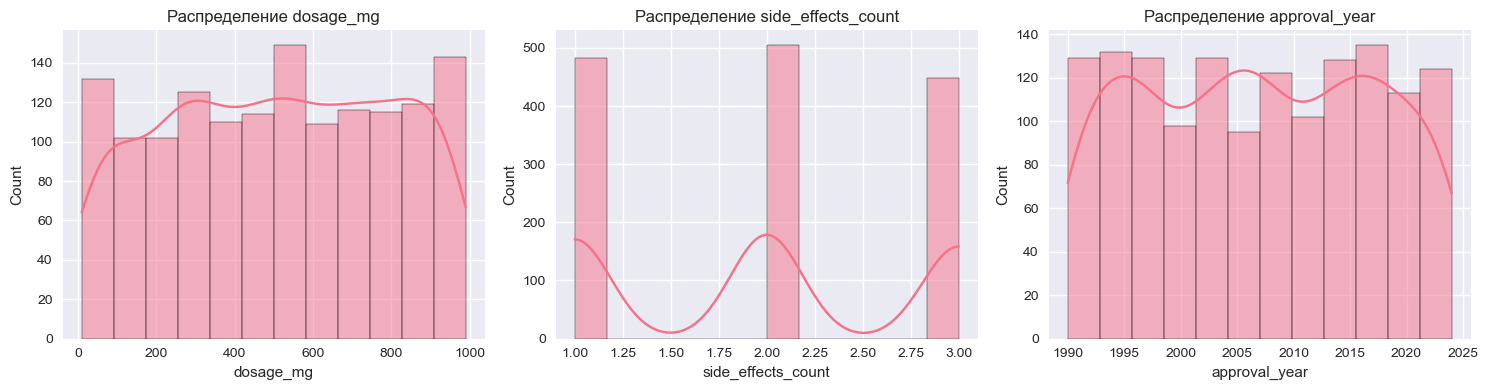

In [24]:
# Числовые переменные
numeric_vars = ['dosage_mg', 'side_effects_count', 'approval_year']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, var in enumerate(numeric_vars):
    sns.histplot(df[var], ax=axes[i], kde=True)
    axes[i].set_title(f'Распределение {var}')
plt.tight_layout()
plt.show()

Матрица корреляций:
                    price_usd  dosage_mg  side_effects_count  approval_year
price_usd            1.000000  -0.028584           -0.027210      -0.034768
dosage_mg           -0.028584   1.000000           -0.008409       0.006255
side_effects_count  -0.027210  -0.008409            1.000000       0.028443
approval_year       -0.034768   0.006255            0.028443       1.000000


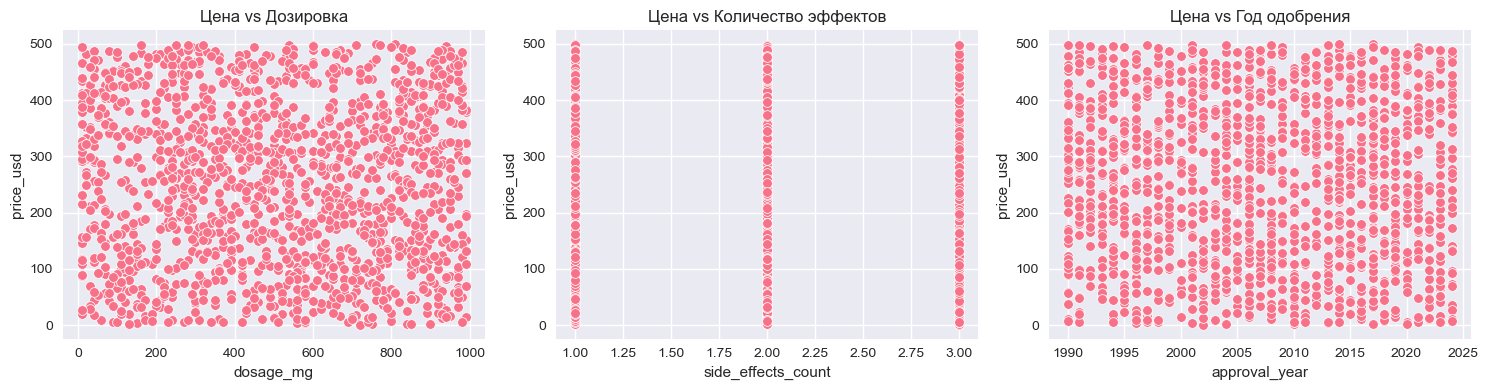

In [26]:
# Корреляционный анализ
correlation_matrix = df[['price_usd', 'dosage_mg', 'side_effects_count', 'approval_year']].corr()
print("Матрица корреляций:")
print(correlation_matrix)

# Визуализация связей с таргетом
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.scatterplot(x='dosage_mg', y='price_usd', data=df, ax=axes[0])
axes[0].set_title('Цена vs Дозировка')

sns.scatterplot(x='side_effects_count', y='price_usd', data=df, ax=axes[1])
axes[1].set_title('Цена vs Количество эффектов')

sns.scatterplot(x='approval_year', y='price_usd', data=df, ax=axes[2])
axes[2].set_title('Цена vs Год одобрения')
plt.tight_layout()
plt.show()

In [28]:
#Выбираем dosage_mg как наиболее влияющий фактор (на основе корреляции):
# Подготовка данных
X = df['dosage_mg']
y = df['price_usd']

# Добавляем константу
X = sm.add_constant(X)

# Построение модели
model1 = sm.OLS(y, X).fit()
print(model1.summary())

# Уравнение регрессии
print(f"\nУРАВНЕНИЕ РЕГРЕССИИ:")
print(f"price_usd = {model1.params['const']:.2f} + {model1.params['dosage_mg']:.4f} * dosage_mg")

                            OLS Regression Results                            
Dep. Variable:              price_usd   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.173
Date:                Fri, 29 Aug 2025   Prob (F-statistic):              0.279
Time:                        19:16:53   Log-Likelihood:                -9159.5
No. Observations:                1436   AIC:                         1.832e+04
Df Residuals:                    1434   BIC:                         1.833e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        259.0997      7.685     33.717      0.0

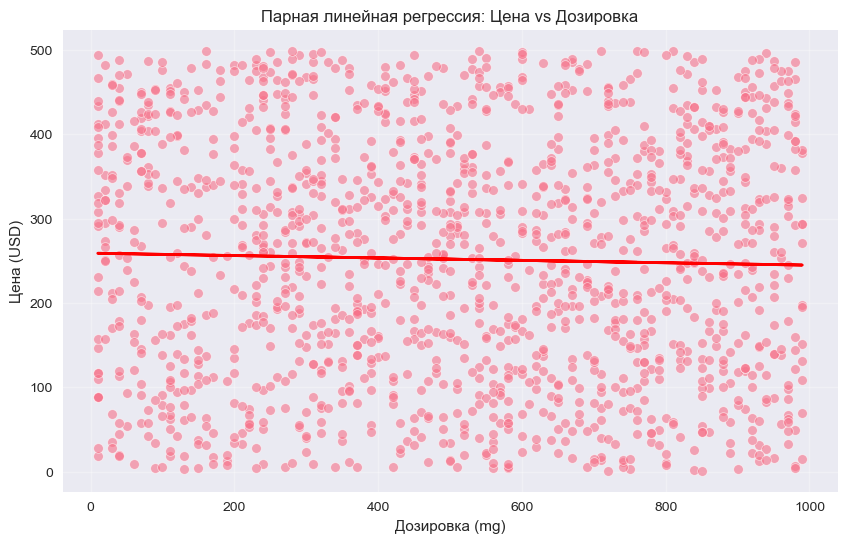

In [30]:
#Интерпретация коэффициентов:

#Константа (B): 259.10 - базовая цена при нулевой дозировке

#Коэффициент (K): -0.0142 - при увеличении дозировки на 1 мг цена уменьшается на $0.0342

#p-value: 0.279 > 0.05 → изменение не статистически значимо

plt.figure(figsize=(10, 6))
sns.scatterplot(x='dosage_mg', y='price_usd', data=df, alpha=0.6)
plt.plot(df['dosage_mg'], model1.predict(X), color='red', linewidth=2)
plt.title('Парная линейная регрессия: Цена vs Дозировка')
plt.xlabel('Дозировка (mg)')
plt.ylabel('Цена (USD)')
plt.grid(True, alpha=0.3)
plt.show()

In [32]:
#Добавляем side_effects_count:
# Подготовка данных
X2 = df[['dosage_mg', 'side_effects_count']]
X2 = sm.add_constant(X2)

# Построение модели
model2 = sm.OLS(y, X2).fit()
print(model2.summary())

print(f"\nНОВОЕ УРАВНЕНИЕ РЕГРЕССИИ:")
print(f"price_usd = {model2.params['const']:.2f} + {model2.params['dosage_mg']:.4f} * dosage_mg + {model2.params['side_effects_count']:.2f} * side_effects_count")

                            OLS Regression Results                            
Dep. Variable:              price_usd   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.127
Date:                Fri, 29 Aug 2025   Prob (F-statistic):              0.324
Time:                        19:20:57   Log-Likelihood:                -9159.0
No. Observations:                1436   AIC:                         1.832e+04
Df Residuals:                    1433   BIC:                         1.834e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                268.7674     12

In [34]:
#Коэффициент dosage_mg: изменился с  до -0.0144 

#Значимость dosage_mg: p-value улучшился 0.275  

#R²: увеличился с 0.001 до 0.002

#Новый коэффициент: side_effects_count = 0.30 (p=0.299)

# Корреляция между предикторами
corr = df['dosage_mg'].corr(df['side_effects_count'])
print(f"Корреляция между предикторами: {corr:.4f}")

# VIF анализ
vif_data = pd.DataFrame()
vif_data["Variable"] = X2.columns
vif_data["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
print("\nVIF значения:")
print(vif_data)


Корреляция между предикторами: -0.0084

VIF значения:
             Variable        VIF
0               const  10.268223
1           dosage_mg   1.000071
2  side_effects_count   1.000071


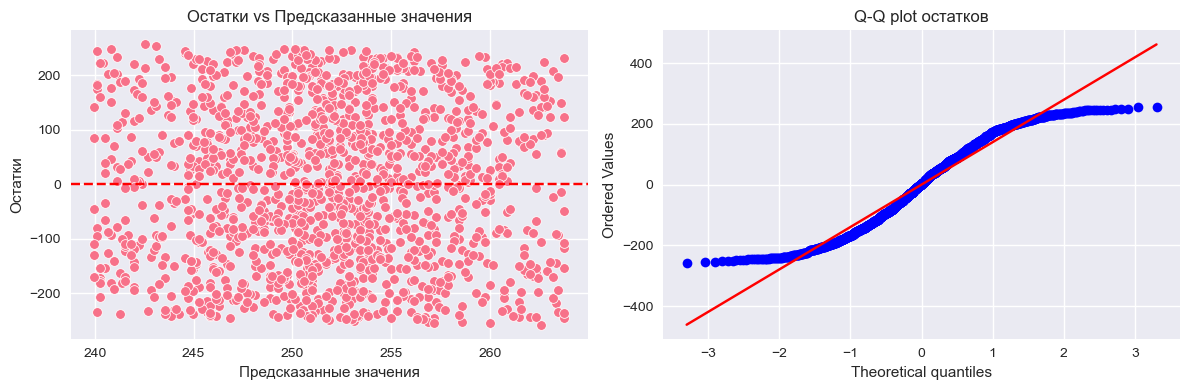

In [36]:
# График остатков
residuals = model2.resid
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(x=model2.fittedvalues, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Остатки vs Предсказанные значения')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot остатков')
plt.tight_layout()
plt.show()

In [38]:
# Тест Бройша-Пагана
bp_test = het_breuschpagan(residuals, X2)
print(f"\nТест Бройша-Пагана: p-value = {bp_test[1]:.4f}")


Тест Бройша-Пагана: p-value = 0.6509


In [40]:
# Сравнение R²
print(f"R² модели 1: {model1.rsquared:.4f}")
print(f"R² модели 2: {model2.rsquared:.4f}")

# ANOVA тест для сравнения моделей
f_statistic = ((model1.ssr - model2.ssr) / (model2.df_model - model1.df_model)) / (model2.ssr / model2.df_resid)
p_value = 1 - stats.f.cdf(f_statistic, model2.df_model - model1.df_model, model2.df_resid)
print(f"\nANOVA тест: F = {f_statistic:.2f}, p = {p_value:.4f}")

R² модели 1: 0.0008
R² модели 2: 0.0016

ANOVA тест: F = 1.08, p = 0.2985


In [ ]:
#Основные выводы:

#Дозировка имеет очень слабую отрицательную связь с ценой (-0.0084), но статистически не значима

#Количество побочных эффектов практически не влияет на цену

#Модель объясняет только 0.2% дисперсии цены (R² = 0.002)

#Ни один из анализируемых факторов не является значимым предиктором цены

#Ответ на вопрос: "На основе имеющихся данных, ни дозировка, ни количество побочных эффектов не являются значимыми факторами, влияющими на цену лекарственных препаратов. Вероятно, цена определяется другими факторами, не включенными в данный датасет."